# QMUL Multiview experiment

This notebook is an experiment aiming to compare the dimensionality reduction capabilities of the RTD-AE, compared to the classical autoencoder and other dimensionality reduction methods, using the [QMUL Multiview Face Dataset](http://www.eecs.qmul.ac.uk/~sgg/QMUL_FaceDataset/). Here, we want to compare the behavior of each dimensionality reduction method when there are "holes" in the initial distribution.

In [69]:
# Imports

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from tqdm import tqdm

The dataset contains 36 sets of pictures of human faces, where each face was taken in horizontal angles ranging from 0 to 180 degrees, and vertical angles ranging from 60 to 120 degrees.

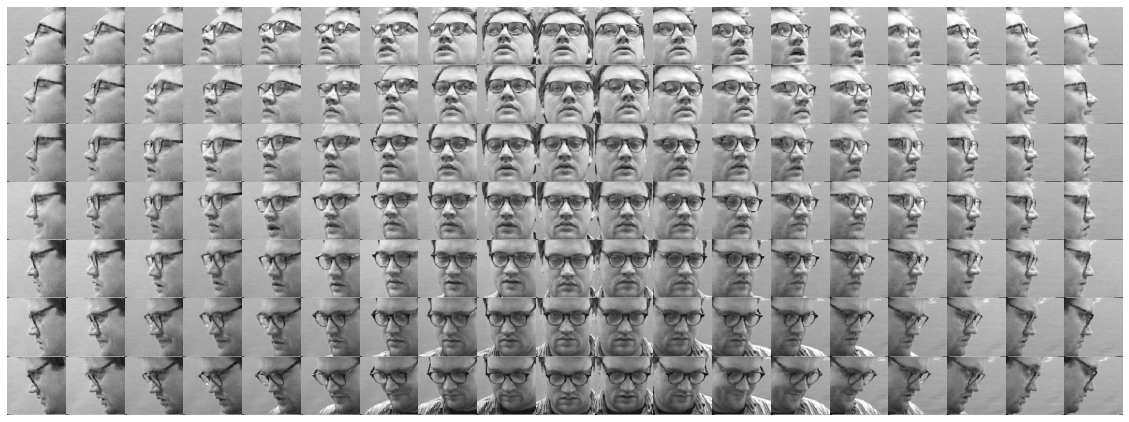

In [4]:
# Plot the images in the dataset
path = "data/QMUL/Set1_Greyscale/AdamBGrey"

x = ["060", "070", "080", "090", "100", "110", "120"]
y = ["000", "010", "020", "030", "040", "050", "060", "070", "080", "090", "100", "110", "120", "130", "140", "150", "160", "170", "180"]

fig, axs = plt.subplots(len(x), len(y), figsize=(20, 7.5))
for i in range(len(x)):
    for j in range(len(y)):
        img = Image.open(os.path.join(path, f"AdamB_{x[i]}_{y[j]}.ras"))
        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
    

When training an autoencoder whcih take these greyscale images as input, with a latent space dimension of 2, we could hope that the autoencoder "learns" a two dimensional manifold, where one axis represents horizontal angles, and another vertical angles. Let us now define first a basic VAE model.

In [58]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        
        # Encoder network
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Latent space
        self.fc_mu = nn.Linear(256 * 6 * 6, latent_dim)
        self.fc_logvar = nn.Linear(256 * 6 * 6, latent_dim)
        
        # Decoder network
        self.fc_dec = nn.Linear(latent_dim, 256 * 6 * 6)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 6, 6)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        z = self.fc_dec(z)
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# VAE Loss Function (Reconstruction + KL Divergence)
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (Binary Cross-Entropy)
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_div


In [59]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [64]:
# PyTorch Dataset of the QMUL Multiview Face dataset
class QMULDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_folders = os.listdir(root_dir)
        self.images = []
        for folder in self.image_folders:
            if os.path.isdir(os.path.join(root_dir, folder)):

                self.images += [folder + "/" + img for img in os.listdir(os.path.join(root_dir, folder)) if img.endswith(".ras")]
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

root_dir = "data/QMUL/Set1_Greyscale"
dataset = QMULDataset(root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

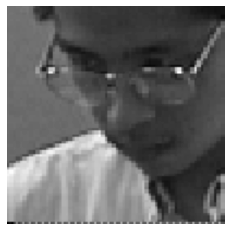

In [65]:
# Plot an image from the dataset
img = dataset[0].squeeze().numpy()
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

In [66]:
latent_dim = 2
model = VAE(latent_dim=latent_dim)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

In [70]:
# Training Loop
epochs = 2
for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    for batch in tqdm(dataloader):
        batch = batch.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar = model(batch)
        loss = vae_loss(recon_batch, batch, mu, logvar)
        
        # Backward pass
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss / len(dataloader.dataset):.4f}')

100%|██████████| 143/143 [01:19<00:00,  1.80it/s]


Epoch [1/2], Loss: 6672.2163


100%|██████████| 143/143 [01:30<00:00,  1.57it/s]

Epoch [2/2], Loss: 6521.1482
